Throughout this Notebook CIFAR10 Dataset is used. You can find the dataset in the following link as well.

[CIFAR10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

# Part 3 (Additional)

Modify the code in Part 2 to carry out stochastic gradient descent with a batch size of 500. 

(a) Report training and testing loss and accuracies.

(b) Compare results with item 2 (justify).

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
#print('x_train: ', x_train.shape)

K = len(np.unique(y_train)) # Classes
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10
# Din = 784 # MINIST

# Normalize pixel values
#x_train, x_test = x_train / 255.0, x_test / 255.0
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

#One-Hot Encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
def find_accuracy(pred,labels):
    pred_class = np.argmax(pred, axis=1)
    ground_truth = np.argmax(labels, axis=1)
    accurate_pred = [pred_class == ground_truth]
    return 100*np.sum(accurate_pred)/len(ground_truth)

In [4]:
def MSE_with_reg(y_pred, ground_truth, batch_size,reg, weights):
  loss = 1./(batch_size*2)*np.square(y_pred-ground_truth).sum() + reg/(batch_size*2)*np.sum([np.sum(w*w) for w in weights])
  return loss;

In [5]:
def batching(lst , m):
  batched = []
  for i in range(round(len(lst)/m)):
    batched.append(lst[i*m:(i+1)*m])
  return batched;
  

In [6]:
def CustomNNwithMiniBatchSGD(batch_size = 500,val_batch_size=10000, epochs = 300, lr = 0.01, lr_decay = 0.999, reg = 1.2):

  std=1e-5
  w1 = std*np.random.randn(Din, 200)
  b1 = np.zeros(200)
  w2 = std*np.random.randn(200, 10)
  b2 = np.zeros(10)

  train_loss_history = []
  val_loss_history = []
  train_acc_history = []
  val_acc_history = []
  total_training_samples = 50000

  seed = 0
  rng = np.random.default_rng(seed=seed)
  indices = np.arange(Ntr)
  rng.shuffle(indices)
  batch_indices = batching(indices, batch_size)

  for epoch in range(1,epochs+1):
    train_loss_per_iteration = []
    train_acc_per_iteration = []

    for batch_indice in batch_indices:
      x = x_train[batch_indice]
      y = y_train[batch_indice]

      h = 1./(1.+np.exp(-(x.dot(w1)+b1)))
      y_pred = h.dot(w2)+b2

      train_loss = MSE_with_reg(y_pred,y,batch_size,reg,[w1,w2])
      train_loss_per_iteration.append(train_loss)
      train_acc = find_accuracy(y_pred, y)
      train_acc_per_iteration.append(train_acc)

      dy = 1.0/batch_size*(y_pred-y)

      dw2 = h.T.dot(dy) + 1./batch_size*reg*w2
      w2 -= lr*dw2

      db2 = dy.sum(axis = 0)
      b2 -= lr*db2

      dh = dy.dot(w2.T)

      dw1 = x.T.dot(dh*h*(1-h)) + 1./batch_size*reg*w1
      w1 -= lr*dw1

      db1 = (dh*h*(1-h)).sum(axis =0)
      b1 -= lr*db1
  
    lr *= lr_decay

    h_val = 1./(1.+np.exp(-(x_test.dot(w1)+b1)))
    y_pred_val = h_val.dot(w2)+b2

    val_loss = MSE_with_reg(y_pred_val,y_test,val_batch_size, reg = 0, weights=[])
    val_loss_history.append(val_loss)
    val_acc = find_accuracy(y_pred_val, y_test)
    val_acc_history.append(val_acc)

    train_loss_per_epoch = sum(train_loss_per_iteration)/len(train_loss_per_iteration)
    train_loss_history.append(train_loss_per_epoch)
    train_acc_per_epoch = sum(train_acc_per_iteration)/len(train_acc_per_iteration)
    train_acc_history.append(train_acc_per_epoch)



    if epoch%10 ==0 or epoch == epochs:
      print('Epoch %d/%d: Train Loss: %f, Val Loss: %f,  Training Accuracy: %f, Validation Accuracy: %f'%(epoch, epochs,train_loss_per_epoch, val_loss, train_acc_per_epoch, val_acc))

  return (train_loss_history, val_loss_history, train_acc_history, val_acc_history, [w1,w2]);


In [8]:
History = CustomNNwithMiniBatchSGD()

Epoch 0/300: Train Loss: 0.421381, Val Loss: 0.404550,  Training Accuracy: 26.662000, Validation Accuracy: 34.470000
Epoch 10/300: Train Loss: 0.355825, Val Loss: 0.376504,  Training Accuracy: 49.364000, Validation Accuracy: 44.010000
Epoch 20/300: Train Loss: 0.331951, Val Loss: 0.377068,  Training Accuracy: 56.402000, Validation Accuracy: 44.950000
Epoch 30/300: Train Loss: 0.316302, Val Loss: 0.375179,  Training Accuracy: 61.288000, Validation Accuracy: 45.370000
Epoch 40/300: Train Loss: 0.304635, Val Loss: 0.382402,  Training Accuracy: 65.182000, Validation Accuracy: 44.430000
Epoch 50/300: Train Loss: 0.295198, Val Loss: 0.385634,  Training Accuracy: 68.228000, Validation Accuracy: 44.150000
Epoch 60/300: Train Loss: 0.286568, Val Loss: 0.395346,  Training Accuracy: 71.080000, Validation Accuracy: 43.500000
Epoch 70/300: Train Loss: 0.281077, Val Loss: 0.401816,  Training Accuracy: 72.936000, Validation Accuracy: 43.180000
Epoch 80/300: Train Loss: 0.273154, Val Loss: 0.403599,  

In [9]:
mean_train_loss = sum(History[0])/len(History[0])
mean_val_loss =sum(History[1])/len(History[1])
mean_train_acc =sum(History[2])/len(History[2])
mean_val_acc =sum(History[3])/len(History[3])
print('Average Train Loss: %f, Average Val Loss: %f,  Average Training Accuracy: %f, Average Validation Accuracy: %f'%(mean_train_loss, mean_val_loss, mean_train_acc, mean_val_acc))


Average Train Loss: 0.262732, Average Val Loss: 0.420060,  Average Training Accuracy: 78.056963, Average Validation Accuracy: 42.352890


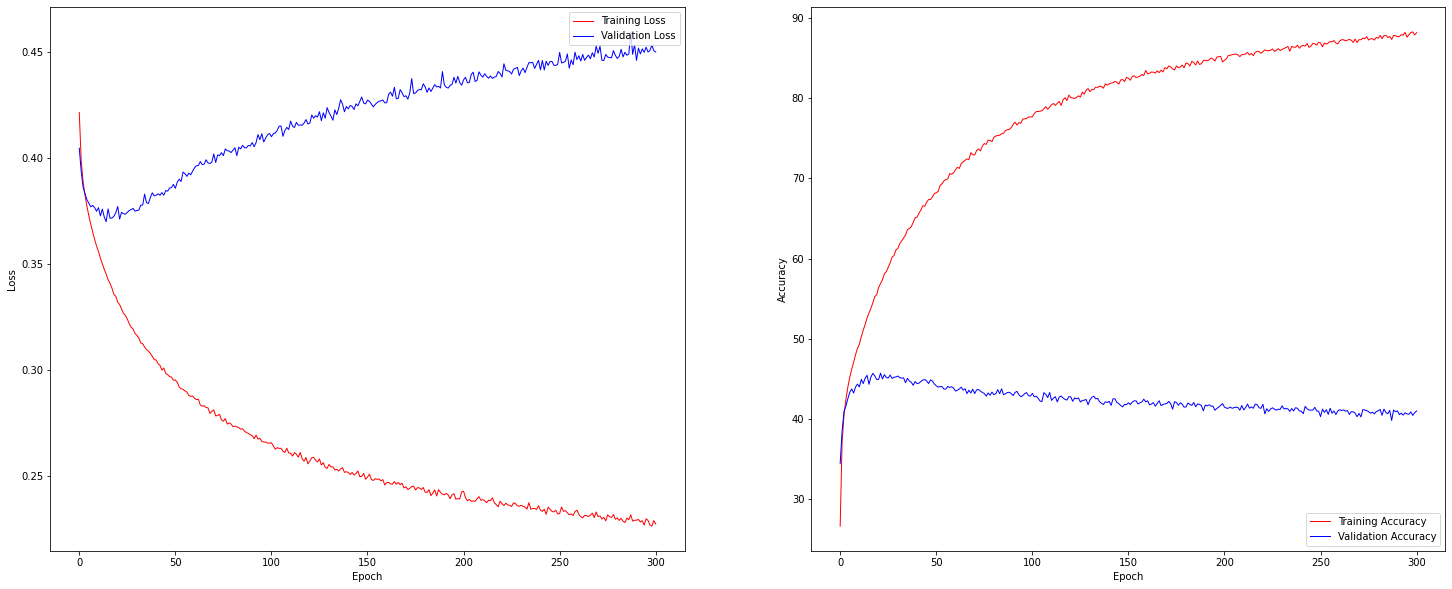

In [10]:
fig, axes  = plt.subplots(1,2, sharex='all', sharey='all', figsize=(25,10))
items = {"Training Loss":History[0], "Validation Loss":History[1], "Training Accuracy":History[2], "Validation Accuracy": History[3]}

plt.subplot(1,2,1);
plt.plot(items['Training Loss'], color ='r', linewidth=1, label ='Training Loss');
plt.plot(items['Validation Loss'], color ='b', linewidth=1, label = 'Validation Loss');
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend(loc='upper right');

plt.subplot(1,2,2);
plt.plot(items['Training Accuracy'], color ='r', linewidth=1, label ='Training Accuracy');
plt.plot(items['Validation Accuracy'], color ='b', linewidth=1, label = 'Validation Accuracy');
plt.xlabel('Epoch');
plt.ylabel('Accuracy');
plt.legend(loc='lower right');
plt.show()


In [12]:
History_1 = CustomNNwithMiniBatchSGD(reg =5.0 , epochs=70)

Epoch 0/70: Train Loss: 0.421624, Val Loss: 0.405383,  Training Accuracy: 26.642000, Validation Accuracy: 34.180000
Epoch 10/70: Train Loss: 0.358338, Val Loss: 0.372416,  Training Accuracy: 49.510000, Validation Accuracy: 44.370000
Epoch 20/70: Train Loss: 0.339247, Val Loss: 0.375040,  Training Accuracy: 55.710000, Validation Accuracy: 44.410000
Epoch 30/70: Train Loss: 0.327299, Val Loss: 0.375645,  Training Accuracy: 60.522000, Validation Accuracy: 45.010000
Epoch 40/70: Train Loss: 0.319601, Val Loss: 0.377527,  Training Accuracy: 63.754000, Validation Accuracy: 45.090000
Epoch 50/70: Train Loss: 0.312729, Val Loss: 0.386464,  Training Accuracy: 66.892000, Validation Accuracy: 44.140000
Epoch 60/70: Train Loss: 0.307883, Val Loss: 0.387497,  Training Accuracy: 69.086000, Validation Accuracy: 44.530000
Epoch 70/70: Train Loss: 0.304157, Val Loss: 0.394940,  Training Accuracy: 71.064000, Validation Accuracy: 43.450000


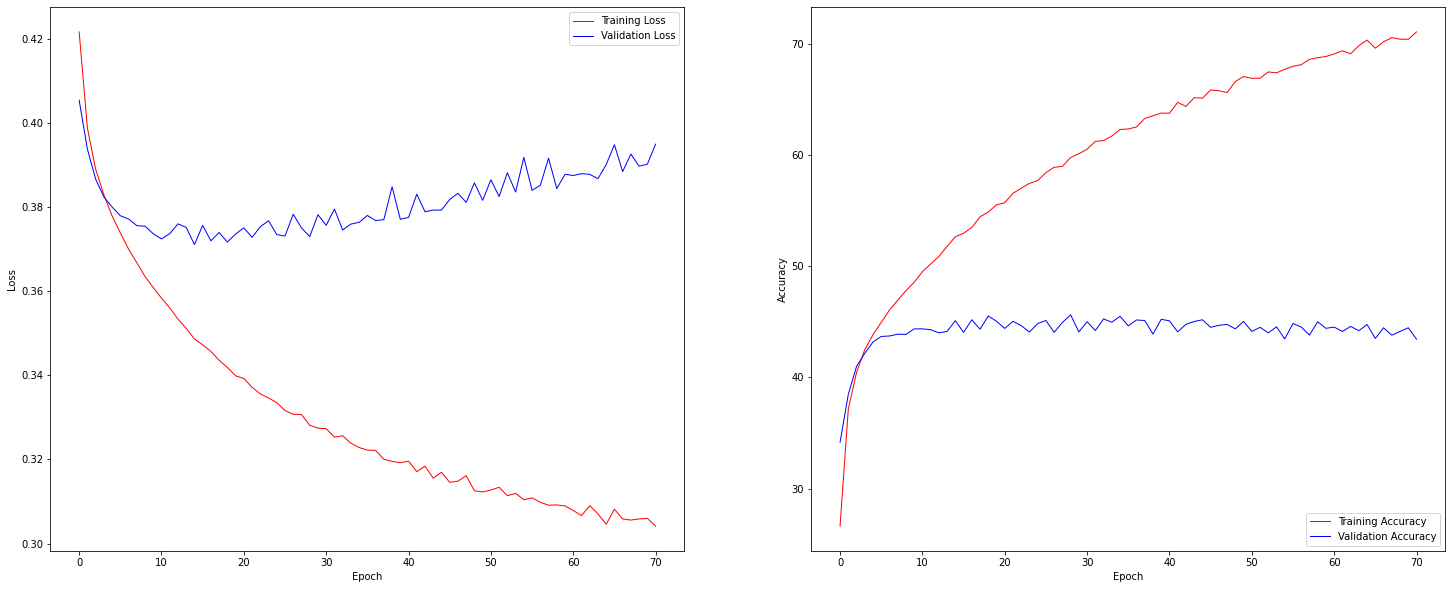

In [13]:
fig, axes  = plt.subplots(1,2, sharex='all', sharey='all', figsize=(25,10))
items = {"Training Loss":History_1[0], "Validation Loss":History_1[1], "Training Accuracy":History_1[2], "Validation Accuracy": History_1[3]}

plt.subplot(1,2,1);
plt.plot(items['Training Loss'], color ='r', linewidth=1, label ='Training Loss');
plt.plot(items['Validation Loss'], color ='b', linewidth=1, label = 'Validation Loss');
plt.xlabel('Epoch');
plt.ylabel('Loss');
plt.legend(loc='upper right');

plt.subplot(1,2,2);
plt.plot(items['Training Accuracy'], color ='r', linewidth=1, label ='Training Accuracy');
plt.plot(items['Validation Accuracy'], color ='b', linewidth=1, label = 'Validation Accuracy');
plt.xlabel('Epoch');
plt.ylabel('Accuracy');
plt.legend(loc='lower right');
plt.show()